## Boundary element for potential problems (2D)

### Constant elements

The Laplace equation, also known as the potential equation, is an elliptic partial differential equation written as

\begin{equation}
    \nabla^2 T = 0
\end{equation}
where $\nabla^2 = \partial^2 / \partial x^2 + \partial^2 / \partial y^2 + \partial^2 / \partial z^2 $ is the Laplace operator and $T$ is an unknown system state, for heat conductivity is the temperature, for potential flows, its the velocity potential.

Consider a square plate of size $L$ \[m\] with an uniform heat conductivity $k$ \[W/m.K\] subjected at opposite faces to a temperature of 100 K and 0 K. There is no heat transfer to the two other opposing faces ($\nabla T = 0, $). Since the heat transfer is only going to occur in one direction, it's reasonable to approximate the Laplace equation to its one-dimensional form 

\begin{equation}
\frac{\partial^2 T}{\partial x^2} = 0.
\end{equation}

Integrating one time, one obtains

\begin{equation}
\frac{\partial T}{\partial x} + C_1 = 0,
\end{equation}
a second integration gives

\begin{equation}
T + C_1 x + C_2 = 0.
\end{equation}

The boundary condition at $x = L$ is $\partial T / \partial x = 100$,
\begin{equation}
\frac{\partial T}{\partial x}(x=L) + C_1 = 100 + C_1 = 0
\end{equation}
\begin{equation}
C_1 = -100
\end{equation}

At $x = 0$,

\begin{equation}
T(x=0) = 0
\end{equation}
so

\begin{equation}
T(x=0) -100 (x=0) + C_2 = 0,
\end{equation}
which gives

\begin{equation}
C_2 = 0.
\end{equation}

The analytical solution is then,

\begin{equation}
T(x) = 100x,\ x \in [0,L]
\end{equation}
for a square of side $L$ and different temperatures in the $y$ direction.


In [3]:
# First, include the module const2D
include("../src/const2D/const2D.jl")
using const2D

In [4]:
# Now, define the geometry
L = 1; # length of the square
k = 1; # heat conductivity of the material
fc = [0]; # no concentrated heat sources 
ne = 15; # number of elements/line segment
POINTS = [1 0 0
	  2 L 0
	  3 L L
	  4 0 L];
SEGMENTS = [1 1 2 0
	     2 2 3 0
	     3 3 4 0
	     4 4 1 0];
MESH = [1 ne
	 2 ne
	 3 ne
	 4 ne];
BCSeg = [1 0 0
	 2 1 0
	 3 1 100
	 4 1 0];
NPX = 11;
NPY = 11;
PONTOS_DOM=const2D.gera_p_in(NPX,NPY,POINTS,SEGMENTS); # generate domain points
n_pdom = size(PONTOS_DOM,1);
PONTOS_dom = zeros(n_pdom,3);
PONTOS_dom[:,2:3] = PONTOS_DOM[:,:];
for i = 1:n_pdom
    PONTOS_dom[i,1] = i;
end
NOS_GEO,NOS,ELEM,CDC,normal = const2D.format_dad(POINTS,SEGMENTS,MESH,BCSeg) # Apply the discretization technique and builds the problems matrices for the geometrical points, physical nodes, elements' connectivity and boundary conditions
nnos = size(NOS,1)  # Number of physical nodes, same as elements when using constant elements
npg=8; # Number of integration points
qsi,w = const2D.Gauss_Legendre(-1,1,npg) # Generation of the points and weights
G,H=const2D.cal_GeHpot(NOS,NOS_GEO,ELEM,k,fc,qsi,w);
A,b = const2D.aplica_CDC(G,H,CDC);
x = A\b # Solves the linear system
T,q = const2D.monta_phieq(CDC,x) # Applies the boundary conditions to return the velocity potential and flux
T_dom,qx_dom,qy_dom = const2D.domain_field(PONTOS_dom[:,2:3]',NOS_GEO[:,2:3]',T,q,ELEM[:,2:3]',normal,k); # Evaluates the value at domain points

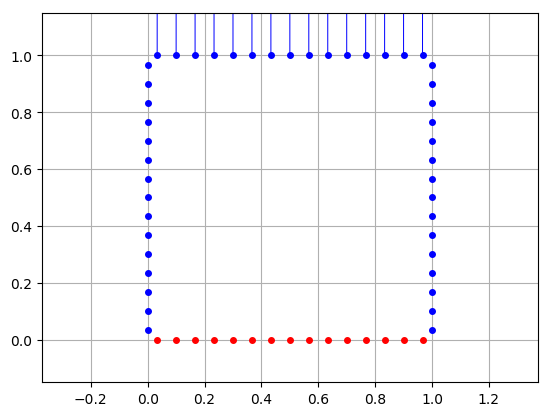

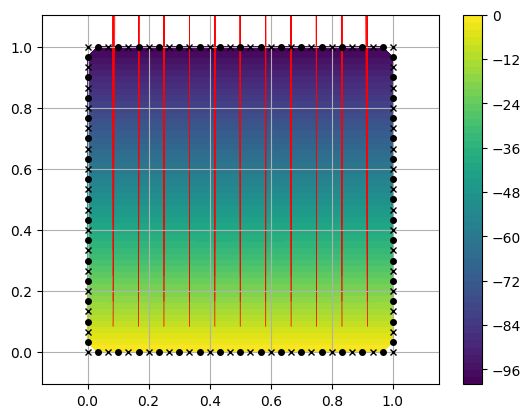

In [5]:
## Now, let's visualize the results
#using PyCall
#using PyPlot
#plt=PyPlot
#@pyimport matplotlib.tri as tri
tipoCDC = zeros(Bool,size(CDC,1));
tipoCDC[:] = CDC[:,2];
valorCDC = CDC[:,3];
const2D.mostra_problema(ELEM[:,2:3],NOS_GEO[:,2:3],NOS[:,2:3],tipoCDC,valorCDC,normal,T,q);
const2D.mostra_heatmap(NOS[:,2:3],PONTOS_dom[:,2:3],real.(T),real.(T_dom),NOS_GEO[:,2:3],ELEM[:,2:3],qx_dom,qy_dom);

### Linear discontinuous elements

### Quadratic discontinuous elements

### NURBS elements

In [1]:
# First, include the module const2D
include("../src/nurbs2D/nurbs2D.jl")
using nurbs2D

In [2]:
# Characteristics of the problem: Square domain with imposed temperature in two opposite faces and imposed null temperature flux at the other two faces. 
L=1;
PONTOS = [1 0 0
	  2 L 0
	  3 L L
	  4 0 L];
SEGMENTOS = [1 1 2 0
	     2 2 3 0
	     3 3 4 0
	     4 4 1 0];
ne = 4;
MALHA = [1 ne
	 2 ne
	 3 ne
	 4 ne];
CCSeg = [1 1 0
	 2 0 1
	 3 1 0
	 4 0 0];
crv = nurbs2D.format_dad_iso(PONTOS,SEGMENTOS,MALHA)
dcrv=map(x->nurbs2D.nrbderiv(x),crv)
n = length(crv);	# N�mero total de elementos
  p=1;#refinamento p
  for i=1:n
      degree=crv[i].order-1
      #	println(crv[i].knots)
      #	println(crv[i].coefs)
      coefs,knots = nurbs2D.bspdegelev(degree,crv[i].coefs,crv[i].knots,p)
      #	println(knots)
      #	println(coefs)
      crv[i] = nurbs2D.nrbmak(coefs,knots)
  end
  h=10;#refinamento h
  for i=1:n
    novosnos=linspace(0,1,h+2)
    degree=crv[i].order-1
    coefs,knots = nurbs2D.bspkntins(degree,crv[i].coefs,crv[i].knots,novosnos[2:end-1])
    crv[i] = nurbs2D.nrbmak(coefs,knots)
  end
z=0;
for k=1:n
	for i=1:crv[k].number
		z=z+1
	end
end
numcurva=zeros(Integer,z)
collocPts=zeros(z)
CDC=zeros(z,3)
collocCoord=zeros(z,3)
z=0;
nnos=zeros(Integer,n)
for k=1:n
	p=crv[k].order-1;
	nnos[k]=crv[k].number;
	valorCDC=CCSeg[k,3];
	tipoCDC=CCSeg[k,2];
	for i=1:crv[k].number
		z=z+1;
		numcurva[z]=k;
		collocPts[z]=sum(crv[k].knots[(i+1):(i+p)])/p;
		if(i==2)
			collocPts[z-1]=(collocPts[z]+collocPts[z-1])/2;
		end
		if(i==nnos[k])
			collocPts[z]=(collocPts[z]+collocPts[z-1])/2;
		end

		CDC[z,:] = [z,tipoCDC,valorCDC];
	end
end
nnos2=cumsum([0 nnos'],2);

E=zeros(length(collocPts),length(collocPts));
for i=1:length(collocPts)
	collocCoord[i,:]=nurbs2D.nrbeval(crv[numcurva[i]], collocPts[i]);
	B, id = nurbs2D.nrbbasisfun(crv[numcurva[i]],collocPts[i])
	E[i,id+nnos2[numcurva[i]]]=B
end
k=1; # Heat conductivity

In [29]:
#Building the problems matrices
H, G = nurbs2D.calcula_iso_POT(collocCoord,nnos2,crv,dcrv,E,k) # Influence matrices
A,b= nurbs2D.aplica_CDCiso(G,H,CDC,E);	# Applying boundary conditions
x=A\b; # Evaluating unknown values
Tc,qc=nurbs2D.monta_Teqiso(CDC,x); # Separating temperature from flux
# Applying NURBS basis functions to the values of temperature and flux
T=E*Tc;
q=E*qc;

# Domain points
PONTOS_int = [1 0.5 0.5]
fc = 0; finc = 0;
Hp,Gp,phi_pint = nurbs2D.calc_phi_pint_nurbs_POT(PONTOS_int,collocCoord,nnos2,crv,dcrv,k,Tc,qc);

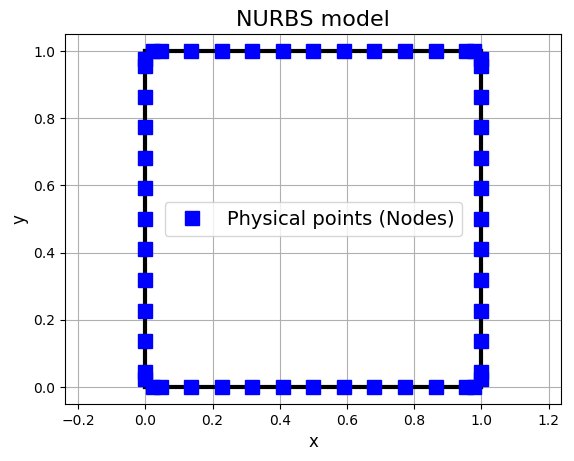

PyObject <matplotlib.legend.Legend object at 0x7fdd8907d940>

In [30]:
# Graphics
nurbs2D.mostra_geo(crv)
nurbs2D.PyPlot.plot(collocCoord[:,1],collocCoord[:,2],marker="s",markersize=10,linestyle="none",color="blue",label = "Physical points (Nodes)")
nurbs2D.PyPlot.axis("equal")
nurbs2D.PyPlot.grid(1)
nurbs2D.PyPlot.xlabel("x",fontsize="12.0")
nurbs2D.PyPlot.ylabel("y",fontsize="12.0")
nurbs2D.PyPlot.title("NURBS model",fontsize="16.0")
nurbs2D.PyPlot.legend(fontsize="14.0",loc="best")

In [31]:
phi_pint

1-element Array{Complex{Float64},1}:
 0.5+0.0im